# Kwant billiard example

**Hit shift+enter or click the <i class="fa-step-forward fa"></i> button above**

**If you are using this notebook at `mybinder.org`, be aware that your changes are temporary and will be erased if you don't download them.**

In order to illustrate how various aspects of Kwant work together when applied to a scattering problem we turn to the classic example of deterministic chaos in a stadium billiard.
Despite their regular shape, stadium billiards are not integrable, showing an irregular density of states inside the scattering region, and universal conductance fluctuations.
Thanks to Kwant's expressiveness, the Python program that defines the billiard system, performs numerical calculations, and creates two figures is less than 30 lines long.
In the following the complete program is presented together with explanations.

The first step is to make Kwant's functionality available within Python,

In [1]:
import kwant

We first need to create the builder object that will contain the information about the system being constructed.
We also create the lattice that is used.

In [2]:
# Build the scattering region.
sys = kwant.Builder()
sqlat = kwant.lattice.square()

We continue with defining a function that specifies the shape of the the scattering region.
Given a point $(x, y)$ this function returns `True` if the point is inside the shape and `False` otherwise.

In [3]:
def stadium(position):
    x, y = position
    x = max(abs(x) - 70, 0)
    return x**2 + y**2 < 100**2

We proceed to add these sites to the scattering region and set the corresponding values of the onsite potential to $-4t$ (we use $t=-1$).

In [4]:
sys[sqlat.shape(stadium, (0, 0))] = 4
sys[sqlat.neighbors()] = -1

The expression `sqlat.shape(stadium, (0, 0))` represents all the sites of the lattice that belong to the stadium (provided they can be reached from the central point $(0, 0)$).

We then set the hopping Hamiltonian matrix elements between nearest neighbors
to $t=-1$:

The scattering region is now fully defined.

To complete the scattering problem, we need to define the leads.
The procedure for a lead is very similar to that for the scattering region.
The only difference between the two is that upon creation of each lead its symmetry is specified.
All further operations with the lead will automatically respect this symmetry: For example, adding a single site to the lead will also add all the image sites under the symmetry as well.
Thus, in order to provide enough information, specifying the structure of a single unit cell is sufficient.
We construct two leads by defining the sites which belong to a unit cell of each lead, and attach them to the scattering region.

In [5]:
# Build and attach the leads, finalize system.
lead_symmetry = kwant.TranslationalSymmetry([0, -1])
for start, end in [(-90, -60), (0, 30)]:
    lead = kwant.Builder(lead_symmetry)
    lead[(sqlat(x, 0) for x in range(start, end))] = 4
    lead[sqlat.neighbors()] = -1
    sys.attach_lead(lead)

This finishes the definition of the scattering problem.

The next required step is to transform the system into a form suitable for efficient numerical calculations:

In [6]:
sys = sys.finalized()

We can now use the Kwant solvers to obtain various physical observables.
We compute the conductance between the two leads given by the [Landauer formula](https://en.wikipedia.org/wiki/Landauer_formula):

In [7]:
# Compute and plot observables.
energies = [0.502 + 1e-4 * i for i in range(50)]  
# (Feel free to calculate more points, but it will take some time)
conductances = [kwant.smatrix(sys, en).transmission(1, 0)
                for en in energies]

...and the local density of states:

In [8]:
local_dos = kwant.ldos(sys, energy=.2)

The function `kwant.smatrix` return the scattering matrix of the system at a given energy.
This scattering matrix is then used to calculate the transmission from one lead to another.
The function `kwant.ldos` returns the local density of states in the scattering region.

We finish the program by plotting the calculated conductance:

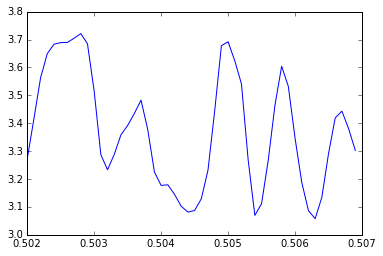

In [9]:
from matplotlib import pyplot
%matplotlib inline
pyplot.plot(energies, conductances);

(which looks somewhat random due to the universal conductance fluctuations)

...and the local density of states, showing the quantum chaos of wave interference:

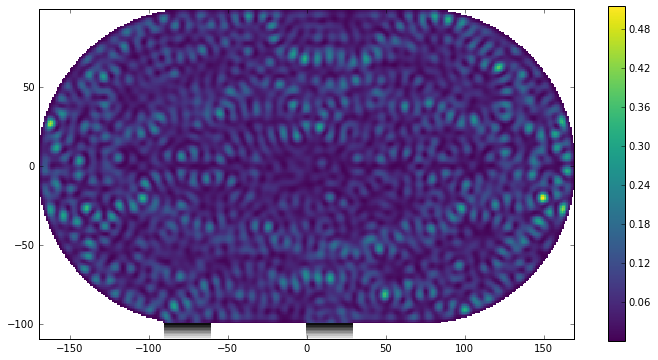

In [10]:
kwant.plotter.map(sys, local_dos, num_lead_cells=10, cmap='viridis', fig_size=(12, 6));